/home/sjim/anaconda3/envs/Jim1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Phi-3...


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Fine-tuning...
Fine-tuning Epoch 1/2 — Avg Loss: nan
Fine-tuning Epoch 2/2 — Avg Loss: nan
Testing...
Parsing error: Not enough matrix rows parsed.. Using zeros.


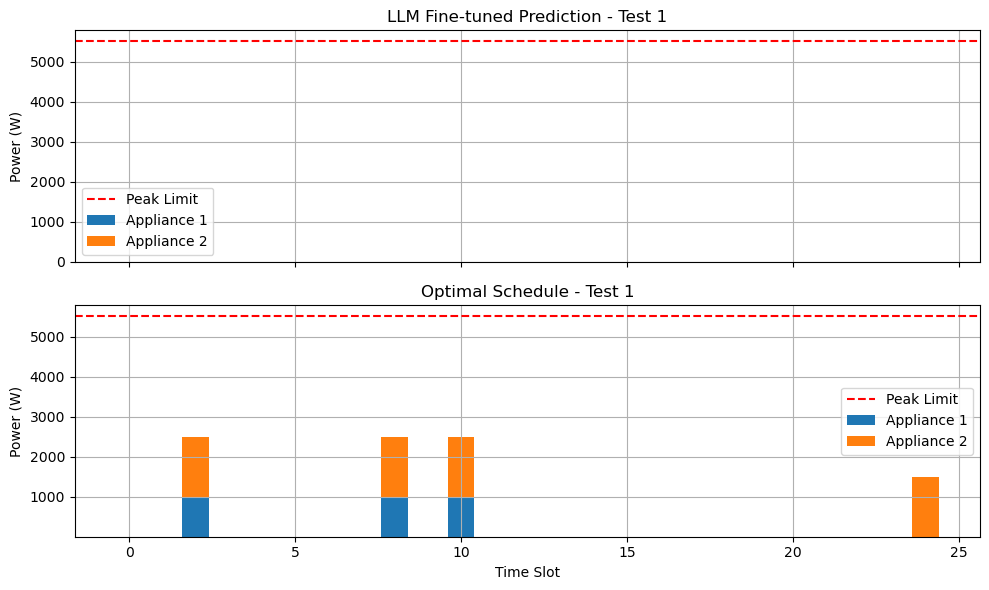

Parsing error: Not enough matrix rows parsed.. Using zeros.


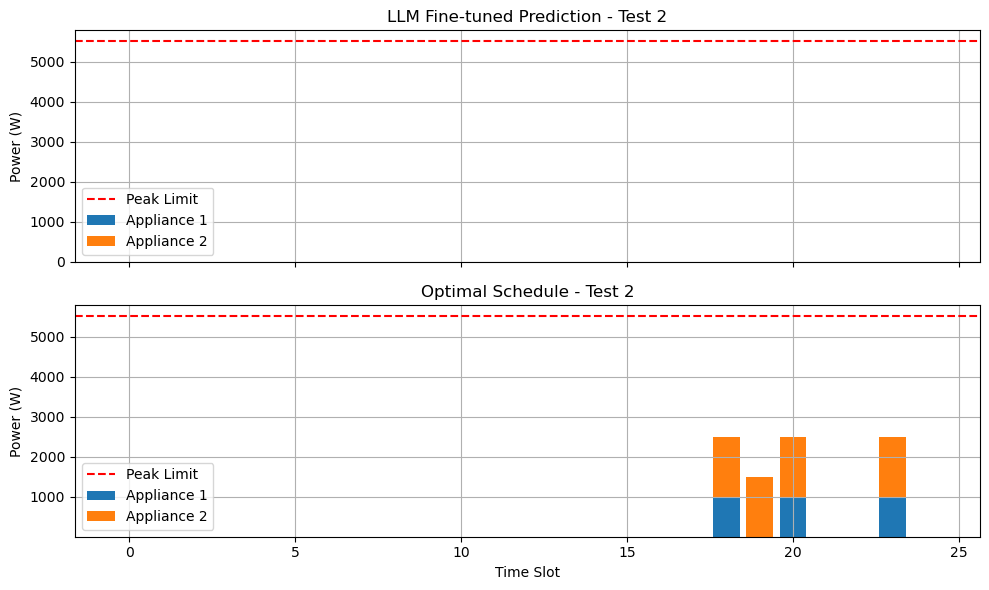

Parsing error: Not enough matrix rows parsed.. Using zeros.


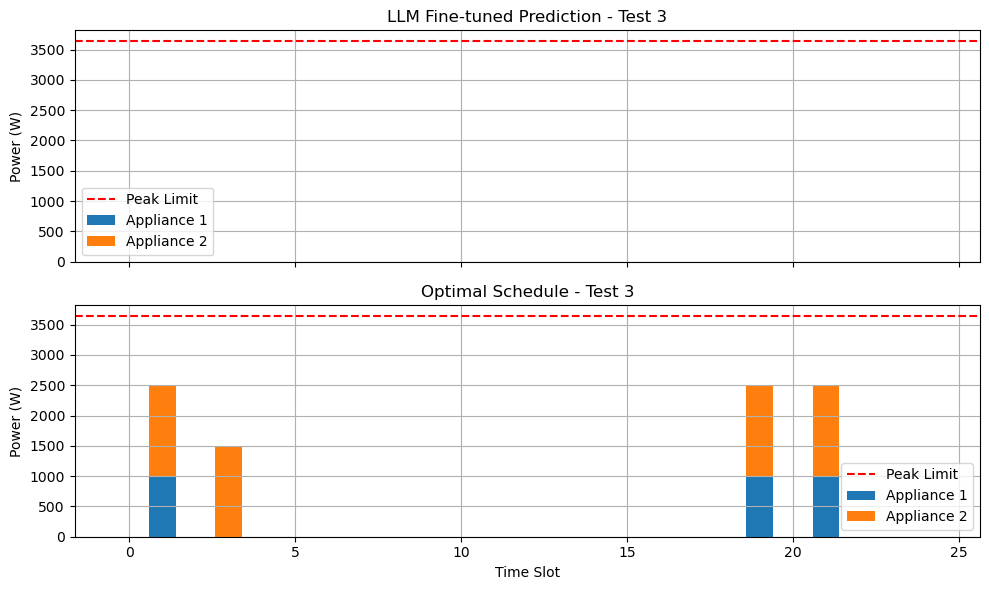

Parsing error: Not enough matrix rows parsed.. Using zeros.


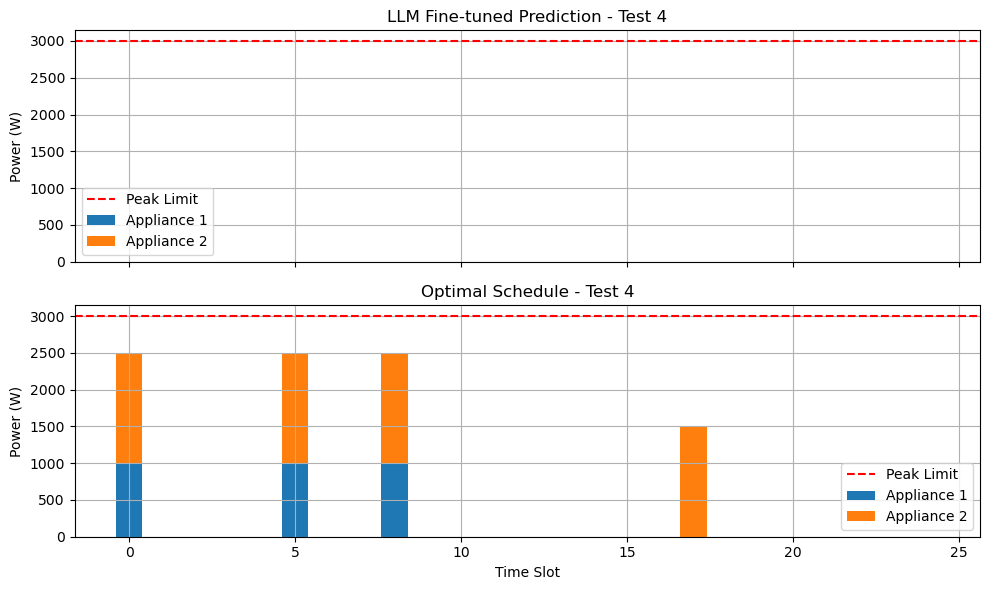

Parsing error: Not enough matrix rows parsed.. Using zeros.


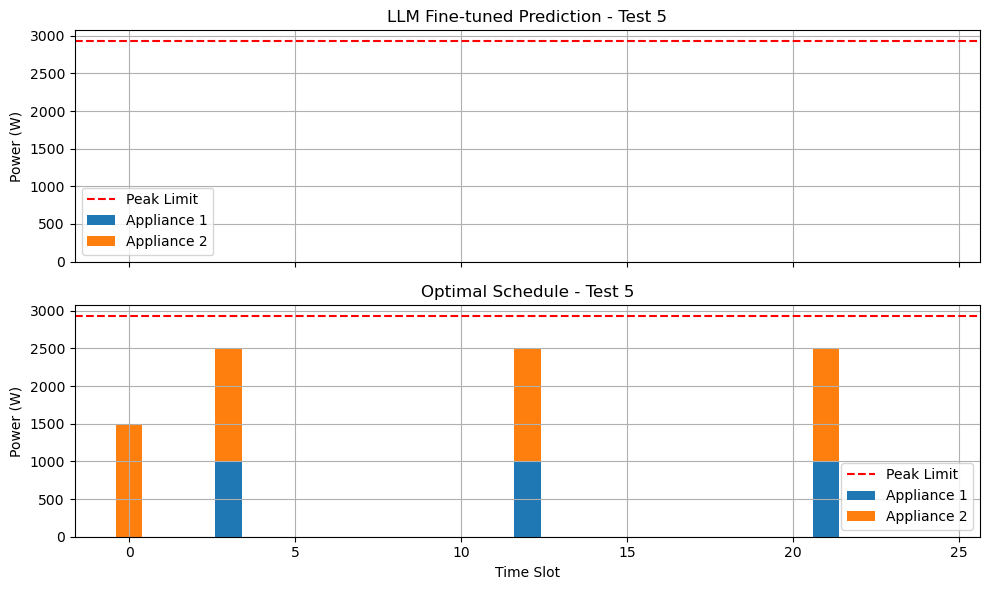


=== Fine-tuned Model Results ===
+--------+------------------+----------------+--------+
|   Test | Predicted Cost   | Optimal Cost   | Gap    |
+========+==================+================+========+
|      1 | $0.00            | $0.64          | $-0.64 |
+--------+------------------+----------------+--------+
|      2 | $0.00            | $0.53          | $-0.53 |
+--------+------------------+----------------+--------+
|      3 | $0.00            | $0.58          | $-0.58 |
+--------+------------------+----------------+--------+
|      4 | $0.00            | $0.55          | $-0.55 |
+--------+------------------+----------------+--------+
|      5 | $0.00            | $0.61          | $-0.61 |
+--------+------------------+----------------+--------+


In [1]:
# Install necessary libraries
!pip install transformers torch cvxpy numpy matplotlib tabulate

# Imports
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cvxpy as cp
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForCausalLM
import re
from tabulate import tabulate

torch.cuda.empty_cache()

# 1) Convex Oracle
def generate_optimal_schedule(price, P_h, E_h, peak_limit):
    N, H = len(price), len(P_h)
    X = cp.Variable((N, H))
    power = cp.multiply(X, P_h.reshape(1, H))
    cost = cp.sum(cp.multiply(price.reshape(N, 1), power)) / 1000.0
    constraints = [
        cp.sum(power, axis=0) >= E_h,
        cp.sum(power, axis=1) <= peak_limit,
        X >= 0, X <= 1
    ]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(verbose=False)
    return X.value.astype(float)

# 2) Dataset for Fine-Tuning
class TSLSupervisedDatasetStructured(Dataset):
    def __init__(self, n_samples, N, H):
        self.prompts = []
        self.targets = []
        self.N, self.H = N, H
        self.P_h = np.array([1000, 1500])
        self.E_h = np.array([3000, 6000])
        self.peak_range = (2000, 6000)

        for _ in range(n_samples):
            price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
            peak_limit = np.random.randint(*self.peak_range)
            X_opt = generate_optimal_schedule(price, self.P_h, self.E_h, peak_limit)
            self.prompts.append(self._build_prompt(price, peak_limit))
            self.targets.append(torch.tensor(X_opt.flatten(), dtype=torch.float32))

    def _build_prompt(self, price, peak_limit):
        s = "[Prices]\n" + "\n".join(f"Slot {i+1}: {p:.3f} $/kWh" for i, p in enumerate(price))
        s += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(self.P_h, self.E_h), start=1):
            s += f"Appliance {i}:\n  Rated Power: {pw/1000:.1f} kW\n  Energy Required: {eg/1000:.1f} kWh\n"
        s += f"\n[Peak Limit]\n{peak_limit/1000:.1f} kW\n"
        s += "\n[Objective]\nMinimize total electricity cost.\n"
        s += f"\n[Output]\nProvide only a {self.N}x{self.H} matrix. Each row two values (0-1), separated by commas. Rows separated by semicolons. No other text.\nExample: 0.0,1.0;1.0,0.0;..."
        return s

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return self.prompts[idx], self.targets[idx]

# 3) Phi Model Wrapper
class PhiScheduler:
    def __init__(self, model_name="microsoft/Phi-3-mini-4k-instruct"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")
        self.model.eval()
        self.N = None
        self.H = None

    def fine_tune(self, dataset, epochs=1, batch_size=4, lr=2e-5):
        self.model.train()
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optimizer = AdamW(self.model.parameters(), lr=lr)

        for ep in range(1, epochs + 1):
            running_loss = 0.0
            for prompts, targets in loader:
                full_texts = []
                for prompt, target in zip(prompts, targets):
                    schedule_text = ";".join(",".join(f"{v:.1f}" for v in target.reshape(self.N, self.H)[i]) for i in range(self.N))
                    full_prompt = prompt + "\n\n" + schedule_text
                    full_texts.append(full_prompt)

                encodings = self.tokenizer(full_texts, return_tensors="pt", padding=True, truncation=True).to(self.model.device)
                outputs = self.model(**encodings, labels=encodings["input_ids"])
                loss = outputs.loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * len(prompts)

            print(f"Fine-tuning Epoch {ep}/{epochs} — Avg Loss: {running_loss/len(dataset):.6f}")

        self.model.eval()
        return self

    def generate_schedule(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(self.model.device)
        outputs = self.model.generate(**inputs, max_new_tokens=500, do_sample=False)
        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return generated_text

# 4) Parse Schedule
def parse_phi_output(output, N, H):
    try:
        matrix_str = re.findall(r"(\d\.\d,\d\.\d;)", output)
        if not matrix_str or len(matrix_str) < N:
            raise ValueError("Not enough matrix rows parsed.")
        schedule = np.zeros((N, H))
        for i, entry in enumerate(matrix_str[:N]):
            values = entry.strip(';').split(',')
            schedule[i] = [float(v) for v in values]
        return np.clip(schedule, 0, 1)
    except Exception as e:
        print(f"Parsing error: {e}. Using zeros.")
        return np.zeros((N, H))

# 5) Testing
def test_and_plot(model, tests=5, N=25, H=2):
    P_h = np.array([1000, 1500])
    E_h = np.array([3000, 6000])
    results = []

    for t_i in range(1, tests+1):
        price = 0.05 + (0.2 - 0.05) * np.random.rand(N)
        peak = np.random.randint(2000, 6000)

        # Build prompt
        p = "[Prices]\n" + "\n".join(f"Slot {i+1}: {v:.3f} $/kWh" for i, v in enumerate(price))
        p += "\n\n[Appliances]\n"
        for i, (pw, eg) in enumerate(zip(P_h, E_h), start=1):
            p += f"Appliance {i}:\n  Rated Power: {pw/1000:.1f} kW\n  Energy Required: {eg/1000:.1f} kWh\n"
        p += f"\n[Peak Limit]\n{peak/1000:.1f} kW\n"
        p += "\n[Objective]\nMinimize total electricity cost.\n"
        p += f"\n[Output]\nProvide only a {N}x2 matrix. Each row two values (0-1), separated by commas. Rows separated by semicolons. No other text.\nExample: 0.0,1.0;1.0,0.0;..."

        # Predict
        output_text = model.generate_schedule(p)
        pred_sched = parse_phi_output(output_text, N, H)
        opt_sched = generate_optimal_schedule(price, P_h, E_h, peak)

        cost_pred = (price[:, None] * (pred_sched * P_h) / 1000.0).sum()
        cost_opt = (price[:, None] * (opt_sched * P_h) / 1000.0).sum()

        results.append({
            'Test': t_i,
            'Predicted Cost': f"${cost_pred:.2f}",
            'Optimal Cost': f"${cost_opt:.2f}",
            'Gap': f"${cost_pred - cost_opt:.2f}"
        })

        # Plot
        t = np.arange(N)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True)

        ax1.bar(t, pred_sched[:,0]*P_h[0], label="Appliance 1")
        ax1.bar(t, pred_sched[:,1]*P_h[1], bottom=pred_sched[:,0]*P_h[0], label="Appliance 2")
        ax1.axhline(peak, color='r', linestyle='--', label="Peak Limit")
        ax1.set_title(f"LLM Fine-tuned Prediction - Test {t_i}")
        ax1.set_ylabel("Power (W)")
        ax1.legend()
        ax1.grid(True)

        ax2.bar(t, opt_sched[:,0]*P_h[0], label="Appliance 1")
        ax2.bar(t, opt_sched[:,1]*P_h[1], bottom=opt_sched[:,0]*P_h[0], label="Appliance 2")
        ax2.axhline(peak, color='r', linestyle='--', label="Peak Limit")
        ax2.set_title(f"Optimal Schedule - Test {t_i}")
        ax2.set_xlabel("Time Slot")
        ax2.set_ylabel("Power (W)")
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    print("\n=== Fine-tuned Model Results ===")
    print(tabulate(results, headers="keys", tablefmt="grid"))

# 6) Main
if __name__ == "__main__":
    N, H = 25, 2
    ds = TSLSupervisedDatasetStructured(2000, N, H)

    print("Loading Phi-3...")
    model = PhiScheduler()
    model.N, model.H = N, H

    print("Fine-tuning...")
    model = model.fine_tune(ds, epochs=2, batch_size=1, lr=2e-5)

    print("Testing...")
    test_and_plot(model, tests=5, N=N, H=H)

In [3]:
pip install "accelerate>=0.26.0"


/bin/bash: /home/sjim/anaconda3/envs/Jim1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
